In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pickle, gzip, urllib.request, json
import math
import time

In [2]:
#To ensure reproducibility
random.seed(11)
np.random.seed(11)

In [3]:
# Load the dataset
urllib.request.urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", "mnist.pkl.gz")
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
    
train_images = train_set[0]
train_labels = train_set[1]

test_images = test_set[0]
test_labels = test_set[1]

# Check that we have the expected shape of arrays, should be (50000, 784), (50000,), (10000, 784), (10000,)
print(train_images.shape)
print(train_labels.shape)

print(test_images.shape)
print(test_labels.shape)

(50000, 784)
(50000,)
(10000, 784)
(10000,)


784
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.     

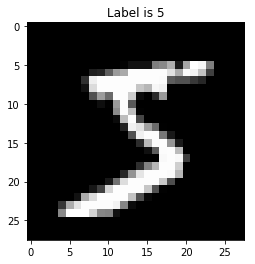

784
(784,)
28
(28, 28)


In [4]:
#Plot the first training image and label
train_sample1 = train_images[0,:]

print(len(train_sample1))

print((train_sample1))

train_sample1 = train_sample1.reshape((28, 28))

label = train_labels[100]



print(len(train_sample1))
print(label)


plt.title('Label is {label}'.format(label=label))
plt.imshow(train_sample1, cmap='gray')
plt.show()


train_sample1 = train_sample1.reshape((784,))
print(len(train_sample1))
print((train_sample1.shape))

weights = np.random.rand(28,28)

print(len(weights[0]))
print(weights.shape)





In [7]:

class boltzmann_machine(object):
    """
    Define a class for a boltzmann machine here.
    You must also define the functions below, but you can add additional arguments, etc.
    Also, note that you are welcome to write your own helper functions. 
    Reminder: you should use numpy functions for vector and matrix operations. No autograd!
    """
    

    # The initialization function for the boltzmann machine
    
    #Variables used for initialization are:
    #1. Number of Hidden Units
    #2. Number of Visible Units
    #3. Weight Matrix
    #4. Learning Rate
    #5. Annealing Schedule
    #6. Training Data
    
    def __init__(self, hidden, visible ,annealing, learning_rate, training):
        
        self.visible=np.random.randint(2, size=(visible))
    
        self.hidden=np.random.randint(2, size=hidden)

        self.units=np.concatenate((self.hidden, self.visible), axis=0)

        self.weights=np.empty(shape=(len(self.hidden),len(self.units)))
        self.weights[:] = np.nan
        
        self.threshold=0
        
        self.annealing=annealing
        
        self.T=1
        
        self.learning_rate=learning_rate
        
        self.training=training


    # method used to initialize weights to a random configuration, weight matrix is |H| by |H+V| with values 
    # with mean 0 and sd 1
    def intializeWeights(self):
        
        for i in range(len(self.hidden)):
            for j in range(i+1,len(self.units)):
                self.weights[i][j]=np.random.normal(0,1)
                


    # methods to initialize co-activation matrix for Awake phase and Dream Phase of the Boltzmann Machine
    def intialize_P_awake(self):
        
        for i in range(len(self.hidden)):
            for j in range(i+1,len(self.units)):
                self.P_awake[i][j]=0
        
    def intialize_P_dream(self):
        
        for i in range(len(self.hidden)):
            for j in range(i+1,len(self.units)):
                self.P_dream[i][j]=0
            
    # sigmoid function to squish values between 0 and 1(used for neuron activation)
    def sigmoid(self,x):     
        return (1/(1+math.exp(-x)))
              


    # method that calculates the probability value for a given neuron(specified by input) to be on or off
    # the method either activates hidden or visible unit
    def activateNeuron(self,neuron):
        summation=0
        neuronNumber=neuron
        
        if neuron<=(len(self.hidden)):
            neuron=neuron-1
            
            for i in range(0,neuron):
                summation=summation+(self.weights[i][neuron]*self.units[i])           
            neuron=neuron+1
        
            for j in range(neuron,len(self.units)):
                summation=summation+(self.weights[neuron-1][j]*self.units[j])  
        else:
            
            neuron=neuron          
            for z in range(0,len(self.hidden)):
                summation=summation+(self.units[z]*self.weights[z][neuron-1])
          
        probability=self.sigmoid(summation/self.T)  
        
        if np.random.binomial(1, probability, 1)==1:
            self.units[neuronNumber-1]=1
        else:
            self.units[neuronNumber-1]=0

    
    # The function for Gibbs sampling while clamped with specific image(Only hidden units are sampled)
    # This corresponds to the Awake Phase P^+
    # this function is also used to calculate the expectated value of the Awake Phase for weight updated
    def gibbs_clamped(self,i,expectation=False):
       
        # if expectation is true this will calculate the expectation of the Awake Phase as it is running Gibbs 
        if expectation==True:
            self.units=np.concatenate((np.random.randint(2, size=len(self.hidden)), self.training[i,:]), axis=0)
            
            #300 samples will be made for hidden units of 25
            for i in range(300):
                self.activateNeuron(random.randint(1,len(self.hidden)))
                self.P_awake=self.P_awake+(np.outer(self.units,self.units)[0:len(self.hidden)])
            self.P_awake=self.P_awake/300
            
        else:  
            self.units=np.concatenate((np.random.randint(2, size=len(self.hidden)), self.training[i,:]), axis=0)
            for i in range(300):
                self.activateNeuron(random.randint(1,len(self.hidden)))
            

    
    # The function for Gibbs sampling with no clamped image(Both Hidden Units and Visible Units are sampled)
    # This corresponds to the Dream Phase P^-
    # this function is also used to calculate the expectated value of the Dream Phase for weight updated
    def gibbs_unclamped(self,expectation=False):
        
         # if expectation is true this will calculate the expectation of the Dream Phase as it is running Gibbs 
        if expectation==True:
            self.units=np.concatenate((np.random.randint(2, size=len(self.hidden)),
                                    np.random.randint(2, size=len(self.visible))), axis=0)
            
            #3000 samples will be made for |H+V| units of 784+25 units
            for i in range(3000):
                self.activateNeuron(random.randint(1,len(self.units)))
                self.P_dream=self.P_dream+(np.outer(self.units,self.units)[0:len(self.hidden)])
            self.P_dream=self.P_dream/3000
                
        else:
            self.units=np.concatenate((np.random.randint(2, size=len(self.hidden)),
                                    np.random.randint(2, size=len(self.visible))), axis=0)
            for i in range(3000):
                self.activateNeuron(random.randint(1,len(self.units)))
                
        
    
    # The function for training the boltzmann machine
    def train(self, numOfImages):
        
        # Awake and Dream expectations for update
        self.P_awake=np.empty(shape=(len(self.hidden),len(self.units)))
        self.P_awake[:] = np.nan
            
        self.P_dream=np.empty(shape=(len(self.hidden),len(self.units)))
        self.P_dream[:] = np.nan
        
        
        # For 100 weight update iterations
        for z in range(100):
            if z%10==0:
                print(z)
            
            #Initialize Awake and Dream expectations for each update
            self.intialize_P_awake()
            self.intialize_P_dream()
                       
            
            #********************Awake Phase(Clamped)**************************
            
            # For a given amount of training images
            for i in range(numOfImages):
                
                # Choose random training image
                image=random.randint(1,len(self.training))
                
                # For the Annealing Schedule run Gibbs Sampling on the given image
                for j in self.annealing:
                    self.T=j
                    self.gibbs_clamped(image)
                
                # For the Annealing Schedule run Sampling & Collect Expectation of the Awake Phase on the given image
                for j in self.annealing:
                    self.T=j
                    self.gibbs_clamped(image,expectation=True)     
             
            # Update Awake Phase expectation
            self.P_awake=self.P_awake/(numOfImages*len(self.annealing))
            
            
            
            
            #********************Dream Phase(NonClamped)*************************
            
            # For the Annealing Schedule run Gibbs Sampling on whole Boltzmann Machine System
            for j in self.annealing:
                self.T=j
                self.gibbs_unclamped()
            
            # For the Annealing Schedule run Sampling & Collect Expectation on whole Boltzmann Machine's Dream Phase
            for j in self.annealing:
                self.T=j
                self.gibbs_unclamped(expectation=True)
            
            # Update Dream Phase expectation
            self.P_dream=self.P_dream/(len(self.annealing))
            
            
            
            #***************Weight Update******************************************
            
            #Calculate Weight Update
            weightUpdate=(self.P_awake-self.P_dream)/self.learning_rate
        
            #Update Weights
            self.weights=self.weights+weightUpdate
                      
    
    
    # The function for testing the boltzmann machine
    # Given a specific image, I clamp it and run gibbs sampling
    # Then i sample without the image and output what the system "Dreams" to see if it is similar
    def test(self,test_image):
        
        boltzmann_machine.gibbs_clamped(test_image)
        boltzmann_machine.gibbs_unclamped()
        show=(boltzmann_machine.units[25:809]).reshape((28, 28))
        plt.imshow(show, cmap='gray')
        plt.show()
        
        



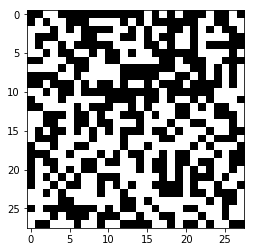

In [8]:
# Create a Boltzmann machine & Plot generated images from your Boltzmann machine running freely (no clamping)

boltzmann_machine=boltzmann_machine(25,784,np.array([100,10,10,1]),5,train_images)
boltzmann_machine.intializeWeights()


boltzmann_machine.gibbs_unclamped()
show=(boltzmann_machine.units[25:809]).reshape((28, 28))
plt.imshow(show, cmap='gray')
plt.show()

In [9]:
#Train Boltzmann Machine 
boltzmann_machine.train(1)


0
10
20
30
40
50
60
70
80
90


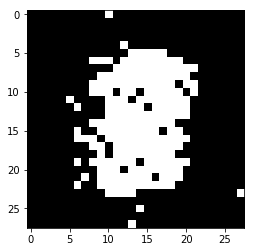

In [21]:
# Plot generated images from your Boltzmann machine running freely after training (no clamping)
boltzmann_machine.gibbs_unclamped()
show=(boltzmann_machine.units[25:809]).reshape((28, 28))
plt.imshow(show, cmap='gray')
plt.show()

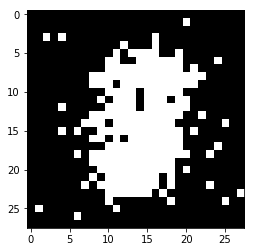

In [12]:
# Test Boltzmann Machine on Clamped images & view output
boltzmann_machine.test(0)

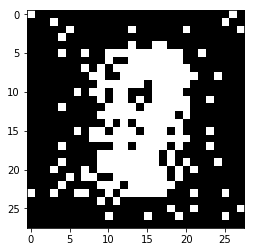

In [13]:
boltzmann_machine.test(1)

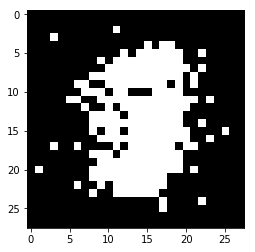

In [20]:
boltzmann_machine.test(5)